# GNN Modeling 

This notebook implements the full GNN modeling pipeline for predicting joint output distributions of quantum circuits.  
Key points:
- Experiments cover 2–5 qubit circuits, with both Class A (Variational Ansatz) and Class B (QAOA-like) families.
- All dataset splits are **stratified** on the measured output bitstring to ensure balanced representation.
- **Transfer learning** is performed across qubit levels: the model for each higher qubit number is initialized with weights from the previous stage.
- Main evaluation metrics: KL divergence, classical fidelity, MSE, Wasserstein distance.
- The same notebook structure will be used for the CNN baseline.

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Imports
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn.functional as F
import torch_geometric
from torch.nn import Linear, Sequential, ReLU, Dropout, BatchNorm1d, LayerNorm
from torch_geometric.nn import TransformerConv, global_mean_pool, global_max_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
import networkx as nx
from scipy.stats import entropy as scipy_entropy
from scipy.stats import wasserstein_distance

## Version Info

In [3]:
print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("PyTorch Geometric version:", torch_geometric.__version__)

Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
PyTorch version: 2.2.2+cu121
PyTorch Geometric version: 2.6.1


## Reproducibility

In [4]:
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

## Device Setup

In [5]:
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Metrics

In [6]:
def kl_divergence_vec(p, q, eps=1e-8):
    """Computes element-wise KL divergence between two probability distributions p and q."""
    p = p + eps
    q = q + eps
    return (p * (p.log() - q.log())).sum(dim=1)


def classical_fidelity_vec(p, q, eps=1e-8):
    """Computes classical fidelity between two distributions as the inner product of square roots."""
    p = p + eps
    q = q + eps
    return (p.sqrt() * q.sqrt()).sum(dim=1)


def wasserstein_vec(p, q):
    """Computes Wasserstein-1 distance for each pair of distributions in a batch."""
    x = np.arange(p.shape[1])
    p_np = p.detach().cpu().numpy()
    q_np = q.detach().cpu().numpy()
    return np.array([
        wasserstein_distance(x, x, p_np[i], q_np[i])
        for i in range(p_np.shape[0])
    ])


def mse_vec(p, q):
    """Computes mean squared error between two batches of vectors with shape correction."""
    if p.shape != q.shape:
        if p.ndim == 2 and p.shape[0] == 1 and q.ndim == 1:
            q = q.unsqueeze(0)
        elif q.ndim == 2 and q.shape[0] == 1 and p.ndim == 1:
            p = p.unsqueeze(0)
        else:
            raise ValueError(f"Shape mismatch in mse_vec: p {p.shape}, q {q.shape}")
    return ((p - q) ** 2).mean(dim=1)


def normalize_distribution(tensor, dim=1, eps=1e-8):
    """Normalizes a tensor along the specified dimension to form a probability distribution."""
    if tensor.dim() == 1:
        return tensor / (tensor.sum() + eps)
    return tensor / (tensor.sum(dim=dim, keepdim=True) + eps)

## Stratified Split and Entropy

In [7]:
def stratified_split(data, key_fn, train_frac=0.7, val_frac=0.2, test_frac=0.1, seed=42):
    """Splits a dataset into train/val/test subsets with stratification based on the most likely output bitstring per sample."""
    random.seed(seed)
    keys = [key_fn(g) for g in data]
    key_to_indices = {}
    for idx, k in enumerate(keys):
        key_to_indices.setdefault(k, []).append(idx)

    train_idx, val_idx, test_idx = [], [], []

    for indices in key_to_indices.values():
        random.shuffle(indices)
        n = len(indices)
        n_train = int(n * train_frac)
        n_val = int(n * val_frac)
        train_idx.extend(indices[:n_train])
        val_idx.extend(indices[n_train:n_train + n_val])
        test_idx.extend(indices[n_train + n_val:])

    return [data[i] for i in train_idx], [data[i] for i in val_idx], [data[i] for i in test_idx]


def outcome_entropy(prob_dist):
    """Computes the Shannon entropy of a probability distribution."""
    prob_dist = prob_dist / (prob_dist.sum() + 1e-8)
    return scipy_entropy(prob_dist, base=2)


def compute_dataset_entropy(data_list):
    """Estimates the entropy of a dataset based on the frequency of output labels."""
    counter = Counter()
    for g in data_list:
        y = g.y
        if isinstance(y, torch.Tensor):
            y = y.detach().cpu().numpy()
        counter.update({i: y[i] for i in range(len(y))})
    dist = np.array([counter.get(i, 0) for i in range(len(counter))], dtype=np.float64)
    return outcome_entropy(dist)

## Topological Position

In [8]:
def add_topological_position_feature(data):
    """
    Appends a normalized topological position feature to each node in a DAG-based circuit graph.

    The feature encodes each node's relative position in a topological sort of the graph.
    """
    G = to_networkx(data, to_undirected=False)
    topo_order = list(nx.topological_sort(G))

    pos = torch.zeros((data.num_nodes, 1), dtype=torch.float32)
    for i, node_id in enumerate(topo_order):
        pos[node_id] = i / (len(topo_order) - 1) if len(topo_order) > 1 else 0.0

    data.x = torch.cat([data.x, pos], dim=1)
    return data

## Dataset Loading

In [9]:
DATASET_ROOT = "../datasets"
CIRCUIT_CLASSES = ["classA", "classB"]
NOISE_TYPES = ["noiseless", "noisy"]


def load_single_dataset(n_qubits, noise_type, circuit_class):
    """
    Loads a single dataset for a given qubit count, noise setting, and class.
    Adds .circuit_class, .noise_regime, .n_qubits metadata to each graph.
    """
    fname = f"dataset_{n_qubits}q_{noise_type}_{circuit_class}.pt"
    fpath = os.path.join(DATASET_ROOT, f"{n_qubits}-qubit", noise_type, circuit_class, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing dataset: {fpath}")
    
    data_list = torch.load(fpath)
    for g in data_list:
        g.circuit_class = circuit_class
        g.noise_regime = noise_type
        g.n_qubits = n_qubits
        g = add_topological_position_feature(g)
    return data_list


def load_all_for_qubit(n_qubits):
    """
    Loads all 4 groups (A/B × noisy/noiseless) for a given qubit size.
    Returns a single combined list of PyG Data objects.
    """
    full_data = []
    for cls in CIRCUIT_CLASSES:
        for noise in NOISE_TYPES:
            data = load_single_dataset(n_qubits, noise, cls)
            full_data.extend(data)
    random.shuffle(full_data)
    return full_data

### GNN Model Definition

In [10]:
class GraphTransformer(torch.nn.Module):
    """
    Graph neural network model using TransformerConv layers to predict output distributions of quantum circuits.

    Applies multiple TransformerConv blocks with residual connections, followed by global pooling and a deep MLP head.
    """
    def __init__(self, node_in_dim, global_u_dim, edge_attr_dim,
                 hidden_dim, output_dim, n_qubits, heads=3, dropout=0.1):
        super().__init__()
        self.input_dim = node_in_dim + global_u_dim

        self.convs = torch.nn.ModuleList([
            TransformerConv(self.input_dim if i == 0 else hidden_dim * heads, hidden_dim, heads=heads,
                           dropout=dropout, edge_dim=edge_attr_dim)
            for i in range(n_qubits)
        ])
        self.bns = torch.nn.ModuleList([
            BatchNorm1d(hidden_dim * heads)
            for _ in range(n_qubits)
        ])
        self.norm = LayerNorm(hidden_dim * heads)
        self.dropout = Dropout(dropout)
        self.relu = ReLU()

        # Widen and deepen MLP
        self.mlp = Sequential(
            Linear(2 * hidden_dim * heads, 2 * hidden_dim * heads),
            ReLU(),
            Dropout(dropout),
            Linear(2 * hidden_dim * heads, hidden_dim * heads),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim * heads, output_dim)
        )

    def forward(self, data):
        x, edge_index, batch, u, edge_attr = data.x, data.edge_index, data.batch, data.u, data.edge_attr

        if u.dim() == 1:
            batch_size = batch.max().item() + 1
            u = u.view(batch_size, -1)
        u_per_node = u[batch]

        x = torch.cat([x, u_per_node], dim=1)
        x_in = x
        for i in range(len(self.convs)):
            x_out = self.dropout(self.relu(self.bns[i](self.convs[i](x_in, edge_index, edge_attr))))
            if i > 0:
                x_out = x_out + x_in
            x_in = x_out
        x_final = self.norm(x_in)

        x_mean = global_mean_pool(x_final, batch)
        x_max = global_max_pool(x_final, batch)
        x_pooled = torch.cat([x_mean, x_max], dim=1)

        return self.mlp(x_pooled)

In [11]:
def build_gnn_model(sample, hidden_dim_2q, heads, dropout):
    """
    Builds a GraphTransformer model based on a sample graph and scaling rules.
    """
    node_in_dim = sample.x.shape[1]
    global_u_dim = sample.u.shape[0]
    edge_attr_dim = sample.edge_attr.shape[1]
    output_dim = sample.y.shape[-1]
    n_qubits = sample.n_qubits

    # Scale hidden_dim with number of qubits
    hidden_dim = int(hidden_dim_2q * (1 + 0.75 * (n_qubits - 2)))

    model = GraphTransformer(
        node_in_dim=node_in_dim,
        global_u_dim=global_u_dim,
        edge_attr_dim=edge_attr_dim,
        hidden_dim=hidden_dim,
        output_dim=output_dim,
        n_qubits=n_qubits,
        heads=heads,
        dropout=dropout
    )
    print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters.")
    return model

## Save Models

In [12]:
def save_model(model, qubit_size, model_dir="../models/gnn_models"):
    os.makedirs(model_dir, exist_ok=True)
    fpath = os.path.join(model_dir, f"{qubit_size}q_gnn.pt")
    torch.save(model.state_dict(), fpath)
    print(f"Saved model to {fpath}")

## Transfer Learning Utilities: Weight Interpolation, Expansion, and Layer Freezing

In [13]:
def interpolate_weights(old_weight, new_shape):
    """Interpolates a tensor to a new shape by copying overlapping values and adding small noise."""
    new_weight = torch.zeros(new_shape)
    min_shape = [min(o, n) for o, n in zip(old_weight.shape, new_shape)]
    slices_old = tuple(slice(0, s) for s in min_shape)
    slices_new = tuple(slice(0, s) for s in min_shape)
    new_weight[slices_new] = old_weight[slices_old]
    if new_weight.shape != old_weight.shape:
        new_weight += torch.randn_like(new_weight) * 0.01
    return new_weight


def expand_and_load_weights(old_state, new_model):
    """Loads weights from a smaller model into a larger model using shape-aware interpolation."""
    new_state = new_model.state_dict()
    updated_state = {}

    for k in new_state:
        if k in old_state:
            old_w = old_state[k]
            new_w = new_state[k]
            if old_w.shape == new_w.shape:
                updated_state[k] = old_w
            else:
                # interpolate
                if old_w.ndim <= 2:
                    updated_state[k] = interpolate_weights(old_w, new_w.shape)
                else:
                    print(f"Skipping complex reshape for: {k}")
        else:
            print(f"Parameter not found in old model: {k}")

    new_state.update(updated_state)
    new_model.load_state_dict(new_state)
    return new_model


def freeze_layers(model, freeze_keys=None):
    """Freezes model parameters whose names contain any of the specified keys."""
    for name, param in model.named_parameters():
        if freeze_keys is None or any(k in name for k in freeze_keys):
            param.requires_grad = False


def unfreeze_all(model):
    """Unfreezes all model parameters."""
    for param in model.parameters():
        param.requires_grad = True


def load_and_expand_model(prev_qubit, sample, hidden_dim_2q, heads, dropout, freeze_epochs=10, model_dir="../models/gnn_models"):
    """Loads a model from a previous qubit size and expands it for the current qubit size with frozen layers."""
    n_qubits = sample.n_qubits
    hidden_dim = hidden_dim_2q + (n_qubits - 2) * 16
    prev_model_path = os.path.join(model_dir, f"{prev_qubit}q_gnn.pt")
    if not os.path.exists(prev_model_path):
        raise FileNotFoundError(f"Model file not found: {prev_model_path}")

    # Build new model
    model = build_gnn_model(sample, hidden_dim_2q, heads, dropout)

    # Load previous model's weights
    state_dict = torch.load(prev_model_path, map_location='cpu')
    model = expand_and_load_weights(state_dict, model)
    print(f"Loaded and interpolated weights from {prev_qubit}q to {sample.n_qubits}q")

    # Freeze shared layers
    freeze_keys = ['convs.0', 'convs.1']
    freeze_layers(model, freeze_keys=freeze_keys)
    print(f"Frozen layers for {freeze_epochs} epochs")

    return model

## Training and Evaluation Functions

In [14]:
# Vectorized model evaluation over loader
def get_metrics_with_std(model, loader):
    """Computes MSE, KL, fidelity, and Wasserstein metrics with means and stds over a DataLoader batch."""
    model.eval()
    all_mse, all_kl, all_fi, all_wass = [], [], [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            target = batch.y
            if target.dim() == 1 and pred.dim() == 2 and target.numel() == pred.numel():
                target = target.view(pred.shape)
            pred_prob = F.softmax(pred, dim=1)
            target_prob = normalize_distribution(target)
            all_mse.append(mse_vec(pred_prob, target_prob).cpu().numpy())
            all_kl.append(kl_divergence_vec(target_prob, pred_prob).cpu().numpy())
            all_fi.append(classical_fidelity_vec(target_prob, pred_prob).cpu().numpy())
            all_wass.append(wasserstein_vec(pred_prob, target_prob))
    return (
        np.mean(np.concatenate(all_mse)), np.std(np.concatenate(all_mse)),
        np.mean(np.concatenate(all_kl)), np.std(np.concatenate(all_kl)),
        np.mean(np.concatenate(all_fi)), np.std(np.concatenate(all_fi)),
        np.mean(np.concatenate(all_wass)), np.std(np.concatenate(all_wass))
    )


def kl_loss(pred_prob, target_prob, eps=1e-8):
    """Computes mean KL divergence loss between predicted and target probability distributions."""
    pred_prob = pred_prob + eps
    target_prob = target_prob + eps
    return torch.mean(torch.sum(target_prob * (target_prob.log() - pred_prob.log()), dim=1))


# training loop
def train_gnn_model(model, train_loader, val_loader, optimizer, epochs=50, freeze_epochs=10):
    """Trains a GNN model using KL loss with early layer freezing for a fixed number of epochs and tracks validation metrics."""
    train_history = {"MSE": [], "KL": [], "FI": [], "W": []}
    val_history = {"MSE": [], "KL": [], "FI": [], "W": []}

    for epoch in range(1, epochs + 1):

        # UNFREEZE
        if epoch == freeze_epochs + 1:
            if any(not p.requires_grad for p in model.parameters()):
                unfreeze_all(model)
                print(f"Unfroze all layers at epoch {epoch}")


        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            pred = model(batch)
            target = batch.y
            if target.dim() == 1 and pred.dim() == 2 and target.numel() == pred.numel():
                target = target.view(pred.shape)
            pred_prob = F.softmax(pred, dim=1)
            target_prob = normalize_distribution(target)
            loss = kl_loss(pred_prob, target_prob)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Metrics logging
        tm, ts, tkl, tkl_s, tfi, tfi_s, tw, tw_s = get_metrics_with_std(model, train_loader)
        vm, vs, vkl, vkl_s, vfi, vfi_s, vw, vw_s = get_metrics_with_std(model, val_loader)
        train_history["MSE"].append(tm)
        train_history["KL"].append(tkl)
        train_history["FI"].append(tfi)
        train_history["W"].append(tw)
        val_history["MSE"].append(vm)
        val_history["KL"].append(vkl)
        val_history["FI"].append(vfi)
        val_history["W"].append(vw)

        print(f"Epoch {epoch:02d} | "
              f"Train MSE: {tm:.5f}±{ts:.5f}, KL: {tkl:.5f}, FI: {tfi:.5f}, W: {tw:.5f} | "
              f"Val MSE: {vm:.5f}±{vs:.5f}, KL: {vkl:.5f}, FI: {vfi:.5f}, W: {vw:.5f}")
        
    return train_history, val_history


# evaluation
def evaluate_model(model, data_list, groupwise=False):
    """Evaluates a trained model on a dataset or per group, returning distributional metrics."""
    from collections import defaultdict

    results = defaultdict(list)
    model.eval()

    if groupwise:
        grouped = defaultdict(list)
        for g in data_list:
            key = (g.circuit_class, g.noise_regime)
            grouped[key].append(g)
        for key, group_data in grouped.items():
            loader = DataLoader(group_data, batch_size=32)
            metrics = get_metrics_with_std(model, loader)
            results[key] = metrics
            print(f"Group {key} \nMSE: {metrics[0]:.6f} ± {metrics[1]:.6f} | "
                  f"KL: {metrics[2]:.6f} | FI: {metrics[4]:.6f} | W: {metrics[6]:.6f}")
    else:
        loader = DataLoader(data_list, batch_size=32)
        metrics = get_metrics_with_std(model, loader)
        results["all"] = metrics
        print(f"Test Set \nMSE: {metrics[0]:.6f} ± {metrics[1]:.6f} | "
              f"KL: {metrics[2]:.6f} | FI: {metrics[4]:.6f} | W: {metrics[6]:.6f}")

    return results

## Visualization

In [15]:
def plot_group_predictions(model, data_list, qubit_size):
    """
    Visualizes predicted vs. true output distributions for one sample from each group
    (Class A/B × Noisy/Noiseless).
    """
    # Generate bitstring labels
    bit_labels = [format(i, f"0{qubit_size}b") for i in range(2 ** qubit_size)]
    group_examples = {}
    # Pick one example per group
    for g in data_list:
        key = (g.circuit_class, g.noise_regime)
        if key not in group_examples:
            group_examples[key] = g
        if len(group_examples) == 4:
            break

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for i, ((cls, noise), g) in enumerate(sorted(group_examples.items())):
        model.eval()
        with torch.no_grad():
            g_batch = Batch.from_data_list([g]).to(model.device if hasattr(model, 'device') else 'cuda')
            pred = model(g_batch)
        pred = F.softmax(pred, dim=1).squeeze().cpu().numpy()
        true = g.y.cpu().numpy()

        x = np.arange(len(true))
        width = 0.4
        axs[i].bar(x - width/2, true, width=width, label="True", alpha=0.7)
        axs[i].bar(x + width/2, pred, width=width, label="Pred", alpha=0.7)
        axs[i].set_title(f"{cls.upper()} | {noise}", fontsize=12)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(bit_labels, rotation=45)
        axs[i].set_ylim(0, max(true.max(), pred.max()) * 1.2)
        axs[i].set_ylabel("Probability")
        axs[i].legend()

    plt.suptitle(f"Predicted vs True Distributions ({qubit_size}Q)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_learning_curves(train_history, val_history, metric_names):
    """
    Plots training and validation metrics across epochs.
    Args:
        train_history: dict mapping metric_name -> list of values (per epoch, train)
        val_history: dict mapping metric_name -> list of values (per epoch, val)
        metric_names: list of metric names (["MSE", "KL", "FI", "W"])
    """
    epochs = range(1, len(next(iter(train_history.values()))) + 1)
    plt.figure(figsize=(12, 8))
    for i, metric in enumerate(metric_names):
        plt.subplot(2, 2, i+1)
        plt.plot(epochs, train_history[metric], label=f"Train {metric}")
        plt.plot(epochs, val_history[metric], label=f"Val {metric}")
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.legend()
        plt.title(f"Learning Curve: {metric}")
    plt.tight_layout()
    plt.show()

In [17]:
def plot_metric_distribution(model, loader, metric_fn, metric_name):
    """
    Plots a boxplot of metric values over all test samples.
    Args:
        model: trained GNN model
        loader: DataLoader (test_loader)
        metric_fn: function(model, batch) → metric vector
        metric_name: str
    """
    model.eval()
    all_metrics = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            target = batch.y
            pred_prob = F.softmax(pred, dim=1)
            target_prob = normalize_distribution(target)
            if pred_prob.shape != target_prob.shape:
                if target_prob.ndim == 1 and pred_prob.ndim == 2 and target_prob.numel() == pred_prob.numel():
                    target_prob = target_prob.view(pred_prob.shape)
                elif pred_prob.ndim == 1 and target_prob.ndim == 2 and pred_prob.numel() == target_prob.numel():
                    pred_prob = pred_prob.view(target_prob.shape)
                elif pred_prob.ndim == 2 and pred_prob.shape[0] == 1 and target_prob.ndim == 1:
                    target_prob = target_prob.unsqueeze(0)
                elif target_prob.ndim == 2 and target_prob.shape[0] == 1 and pred_prob.ndim == 1:
                    pred_prob = pred_prob.unsqueeze(0)
                else:
                    raise ValueError(f"Shape mismatch: pred_prob {pred_prob.shape}, target_prob {target_prob.shape}")
            vals = metric_fn(pred_prob, target_prob)
            if hasattr(vals, 'cpu'):
                vals = vals.cpu().numpy()
            all_metrics.extend(vals)
    plt.figure(figsize=(6, 4))
    plt.boxplot(all_metrics, vert=True, patch_artist=True)
    plt.title(f"Distribution of {metric_name} on Test Set")
    plt.ylabel(metric_name)
    plt.show()

## Experiment Wrapper

In [18]:
def run_qubit_experiment(qubit_size, hidden_dim_2q=48, heads=3, dropout=0.1, epochs=50, freeze_epochs=10):
    """Runs GNN training, evaluation, and visualization pipeline for a given qubit size."""
    print(f"\n{qubit_size}-Qubit GNN Experiment")

    #Load and prepare data
    current_data = load_all_for_qubit(qubit_size)
    print(f"Loaded {len(current_data)} samples.")

    full_entropy = compute_dataset_entropy(current_data)
    print(f"Full set outcome entropy: {full_entropy:.4f} bits")

    def bitstring_argmax(g):
        return int(torch.argmax(g.y).item())

    train_data, val_data, test_data = stratified_split(
        current_data, key_fn=bitstring_argmax,
        train_frac=0.7, val_frac=0.2, test_frac=0.1, seed=42
    )

    print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")
    print(f"Entropy \nTrain: {compute_dataset_entropy(train_data):.4f}, "
          f"Val: {compute_dataset_entropy(val_data):.4f}, "
          f"Test: {compute_dataset_entropy(test_data):.4f}")

    # Build loaders
    BATCH_SIZE = 32
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    # Model init with transfer logic
    sample = train_data[0]
    if qubit_size == 2:
        model = build_gnn_model(sample, hidden_dim_2q, heads, dropout)
    else:
        model = load_and_expand_model(qubit_size - 1, sample, hidden_dim_2q, heads, dropout,
                                      freeze_epochs=freeze_epochs)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = kl_loss

    #Train
    print("Starting training...")
    train_history, val_history = train_gnn_model(model, train_loader, val_loader, optimizer,
                                                 epochs=epochs, freeze_epochs=freeze_epochs)

    # Visualization: Learning Curves
    print("Plotting learning curves...")
    plot_learning_curves(train_history, val_history, metric_names=["MSE", "KL", "FI", "W"])

    # Evaluate
    print("Evaluating on test set...")
    results = evaluate_model(model, test_data, groupwise=True)
    for (cls, noise), metrics in results.items():
        mse, mse_s, kl, kl_s, fi, fi_s, wass, wass_s = metrics
        print(f"{cls.upper()} | {noise:<9} \n "
              f"MSE: {mse:.5f}, KL: {kl:.5f}, FI: {fi:.5f}, W: {wass:.5f}")

    #Visualization Metric Distributions
    print("Plotting metric distributions on test set...")
    plot_metric_distribution(model, test_loader, mse_vec, "MSE")
    plot_metric_distribution(model, test_loader, kl_divergence_vec, "KL Divergence")
    plot_metric_distribution(model, test_loader, classical_fidelity_vec, "Fidelity")
    plot_metric_distribution(model, test_loader, wasserstein_vec, "Wasserstein")

    # Visualization: Example Group Predictions
    print("Visualizing predictions (per-group samples)...")
    plot_group_predictions(model, test_data, qubit_size=qubit_size)

    # Save model
    save_model(model, qubit_size)

**Important Note: KL and Fidelity boxplots**
>
> The KL divergence and fidelity boxplots shown in this notebook (via `plot_metric_distribution`) are **incorrect** due to a bug in the metric direction.
>
> **For the correct and properly computed KL divergence and fidlity distributions, refer to:**  
> `gnn_kl-fid_boxplot_visualization.ipynb`
>
> All KL and Fidelity values printed in the output are correct; only the *distribution visualizations* are affected.
>
> This note is to prevent confusion in reviewing.

## 2-qubit experiment

This section presents experiments on 2-qubit quantum circuits.
We train and evaluate the model's ability to predict full output distributions across both circuit classes (Class A and Class B) and under two noise regimes (noiseless and noisy).
The same procedure will be applied to higher qubit sizes in subsequent sections.


2-Qubit GNN Experiment
Loaded 9600 samples.
Full set outcome entropy: 2.0000 bits
Train: 6718, Val: 1918, Test: 964
Entropy 
Train: 2.0000, Val: 2.0000, Test: 1.9999
Model has 232,564 parameters.
Starting training...
Epoch 01 | Train MSE: 0.00877±0.01190, KL: 0.08192, FI: 0.97688, W: 0.18241 | Val MSE: 0.00878±0.01209, KL: 0.08210, FI: 0.97672, W: 0.18127
Epoch 02 | Train MSE: 0.00810±0.01196, KL: 0.07589, FI: 0.97854, W: 0.16644 | Val MSE: 0.00811±0.01219, KL: 0.07616, FI: 0.97835, W: 0.16571
Epoch 03 | Train MSE: 0.00755±0.01205, KL: 0.07119, FI: 0.97976, W: 0.15527 | Val MSE: 0.00763±0.01224, KL: 0.07199, FI: 0.97944, W: 0.15556
Epoch 04 | Train MSE: 0.00736±0.01216, KL: 0.06941, FI: 0.98033, W: 0.14674 | Val MSE: 0.00745±0.01231, KL: 0.07029, FI: 0.97999, W: 0.14723
Epoch 05 | Train MSE: 0.00711±0.01226, KL: 0.06697, FI: 0.98095, W: 0.13915 | Val MSE: 0.00717±0.01241, KL: 0.06780, FI: 0.98061, W: 0.13930
Epoch 06 | Train MSE: 0.00686±0.01207, KL: 0.06501, FI: 0.98154, W: 0.13272 |

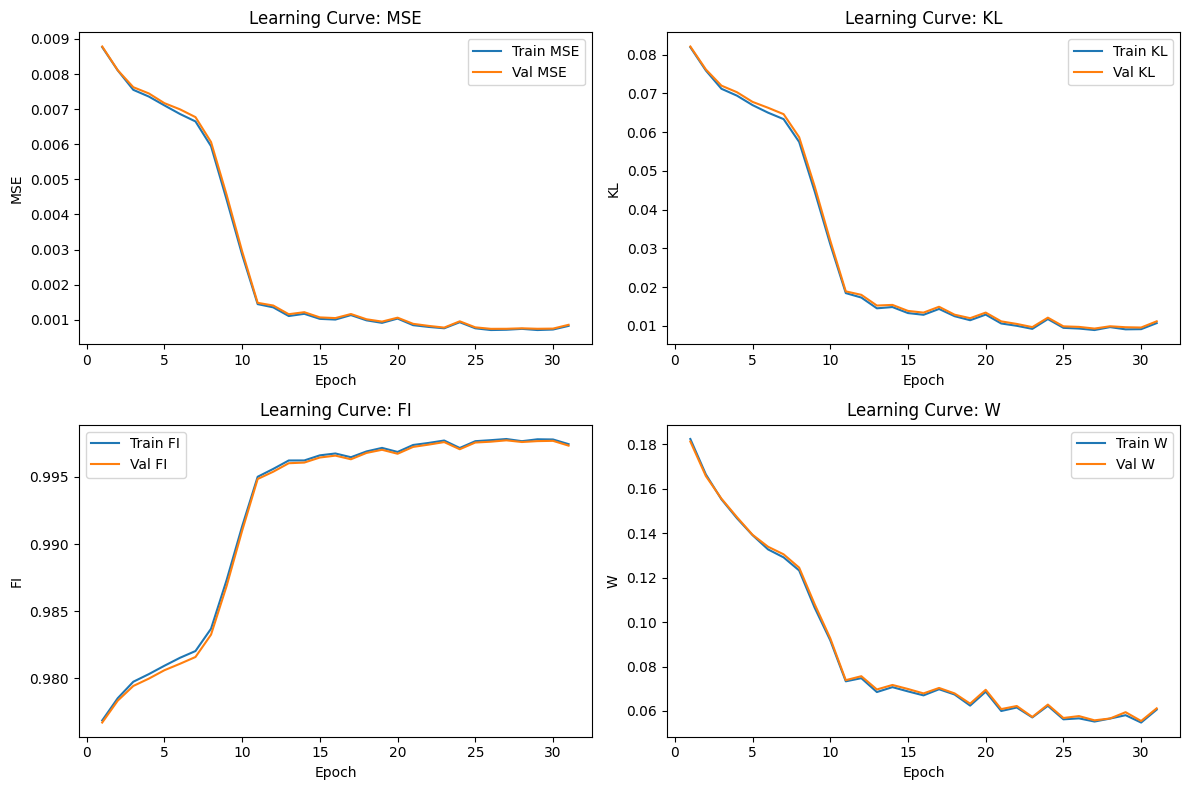

Evaluating on test set...
Group ('classB', 'noisy') 
MSE: 0.001035 ± 0.000993 | KL: 0.013123 | FI: 0.996909 | W: 0.066045
Group ('classB', 'noiseless') 
MSE: 0.001381 ± 0.001543 | KL: 0.018274 | FI: 0.995658 | W: 0.072468
Group ('classA', 'noisy') 
MSE: 0.000460 ± 0.000384 | KL: 0.006269 | FI: 0.998530 | W: 0.053252
Group ('classA', 'noiseless') 
MSE: 0.000501 ± 0.000436 | KL: 0.006906 | FI: 0.998210 | W: 0.055104
CLASSB | noisy     
 MSE: 0.00104, KL: 0.01312, FI: 0.99691, W: 0.06604
CLASSB | noiseless 
 MSE: 0.00138, KL: 0.01827, FI: 0.99566, W: 0.07247
CLASSA | noisy     
 MSE: 0.00046, KL: 0.00627, FI: 0.99853, W: 0.05325
CLASSA | noiseless 
 MSE: 0.00050, KL: 0.00691, FI: 0.99821, W: 0.05510
Plotting metric distributions on test set...


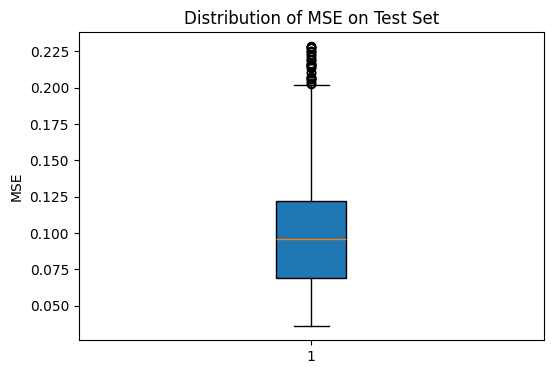

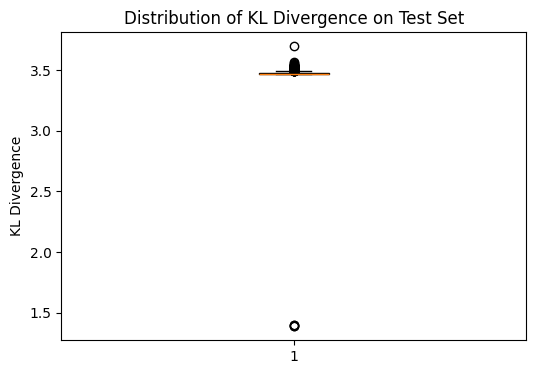

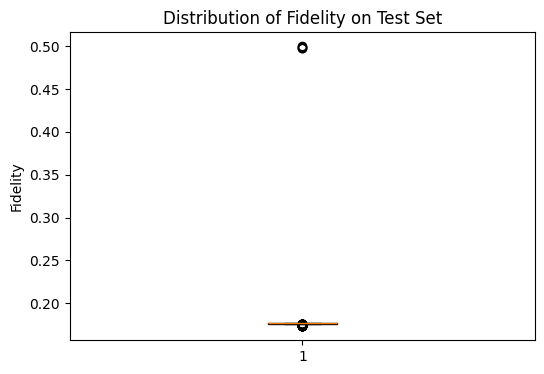

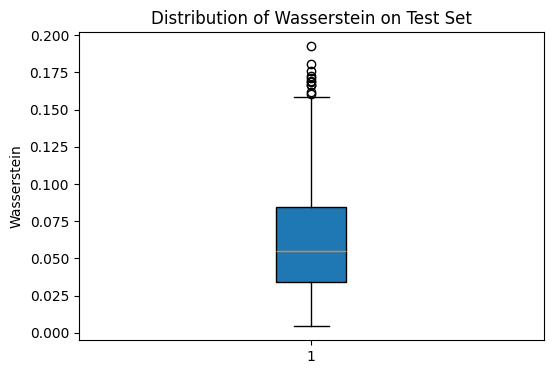

Visualizing predictions (per-group samples)...


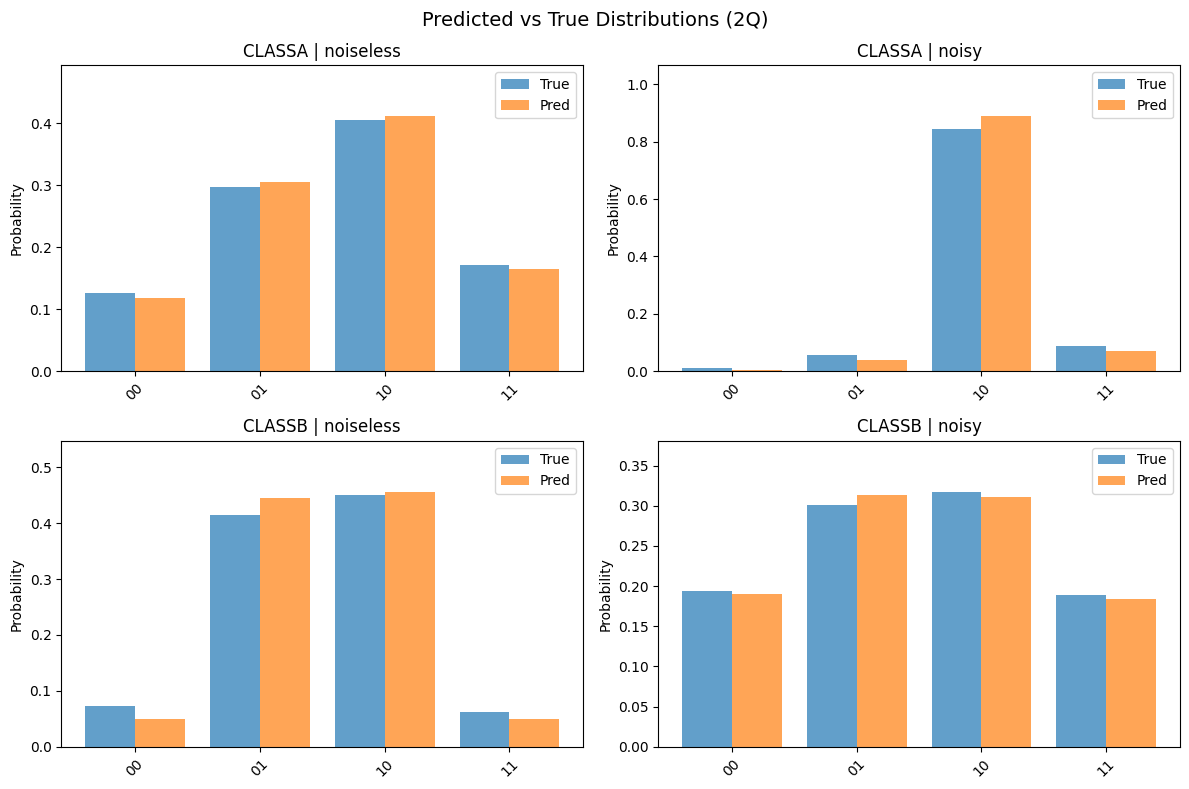

Saved model to ../models/gnn_models\2q_gnn.pt


In [19]:
run_qubit_experiment(2, epochs=31)

## 3-qubit experiment


3-Qubit GNN Experiment
Loaded 19200 samples.
Full set outcome entropy: 2.9927 bits
Train: 13437, Val: 3837, Test: 1926
Entropy 
Train: 2.9926, Val: 2.9925, Test: 2.9931
Model has 936,440 parameters.
Parameter not found in old model: convs.2.lin_key.weight
Parameter not found in old model: convs.2.lin_key.bias
Parameter not found in old model: convs.2.lin_query.weight
Parameter not found in old model: convs.2.lin_query.bias
Parameter not found in old model: convs.2.lin_value.weight
Parameter not found in old model: convs.2.lin_value.bias
Parameter not found in old model: convs.2.lin_edge.weight
Parameter not found in old model: convs.2.lin_skip.weight
Parameter not found in old model: convs.2.lin_skip.bias
Parameter not found in old model: bns.2.weight
Parameter not found in old model: bns.2.bias
Parameter not found in old model: bns.2.running_mean
Parameter not found in old model: bns.2.running_var
Parameter not found in old model: bns.2.num_batches_tracked
Loaded and interpolated wei

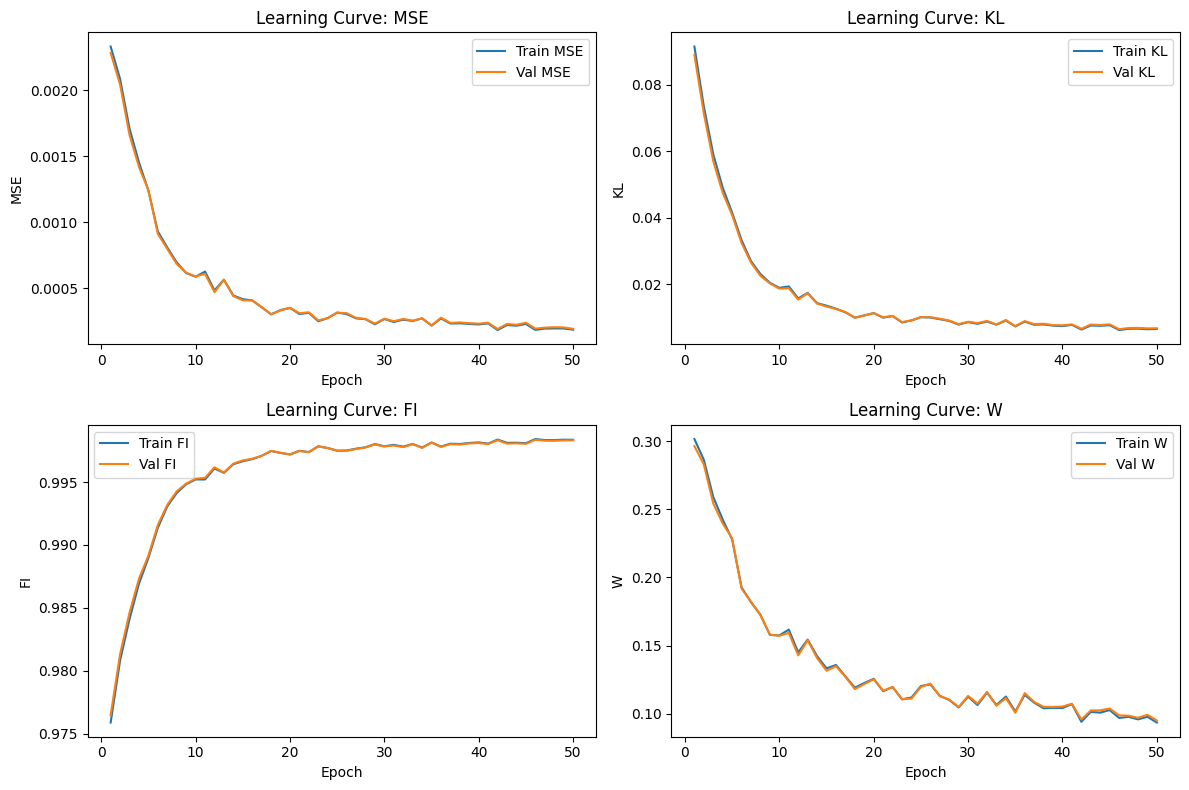

Evaluating on test set...
Group ('classB', 'noiseless') 
MSE: 0.000177 ± 0.000131 | KL: 0.007559 | FI: 0.998157 | W: 0.091916
Group ('classB', 'noisy') 
MSE: 0.000137 ± 0.000091 | KL: 0.004745 | FI: 0.998828 | W: 0.084761
Group ('classA', 'noisy') 
MSE: 0.000244 ± 0.000193 | KL: 0.007472 | FI: 0.998177 | W: 0.103606
Group ('classA', 'noiseless') 
MSE: 0.000209 ± 0.000207 | KL: 0.007514 | FI: 0.998119 | W: 0.097672
CLASSB | noiseless 
 MSE: 0.00018, KL: 0.00756, FI: 0.99816, W: 0.09192
CLASSB | noisy     
 MSE: 0.00014, KL: 0.00475, FI: 0.99883, W: 0.08476
CLASSA | noisy     
 MSE: 0.00024, KL: 0.00747, FI: 0.99818, W: 0.10361
CLASSA | noiseless 
 MSE: 0.00021, KL: 0.00751, FI: 0.99812, W: 0.09767
Plotting metric distributions on test set...


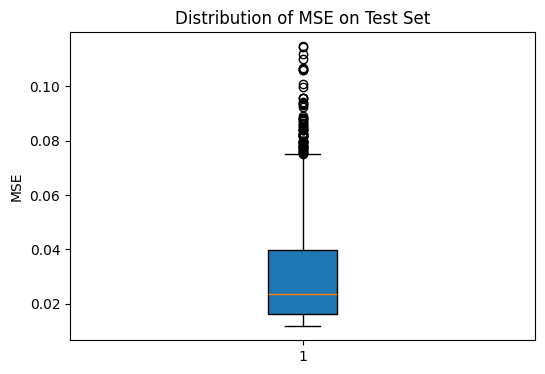

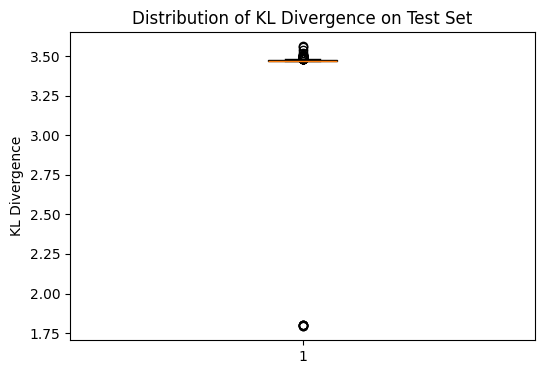

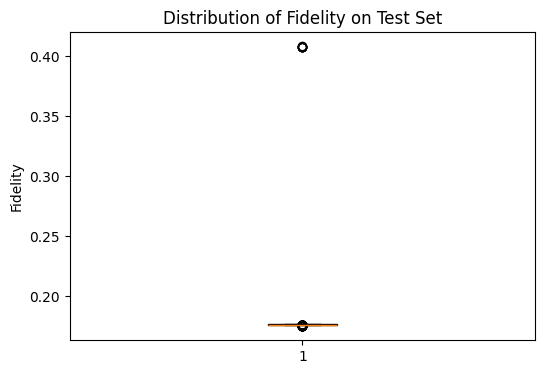

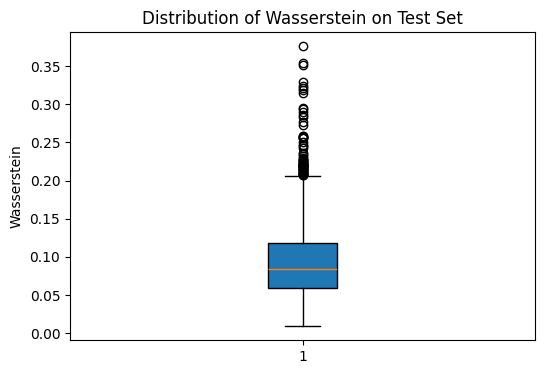

Visualizing predictions (per-group samples)...


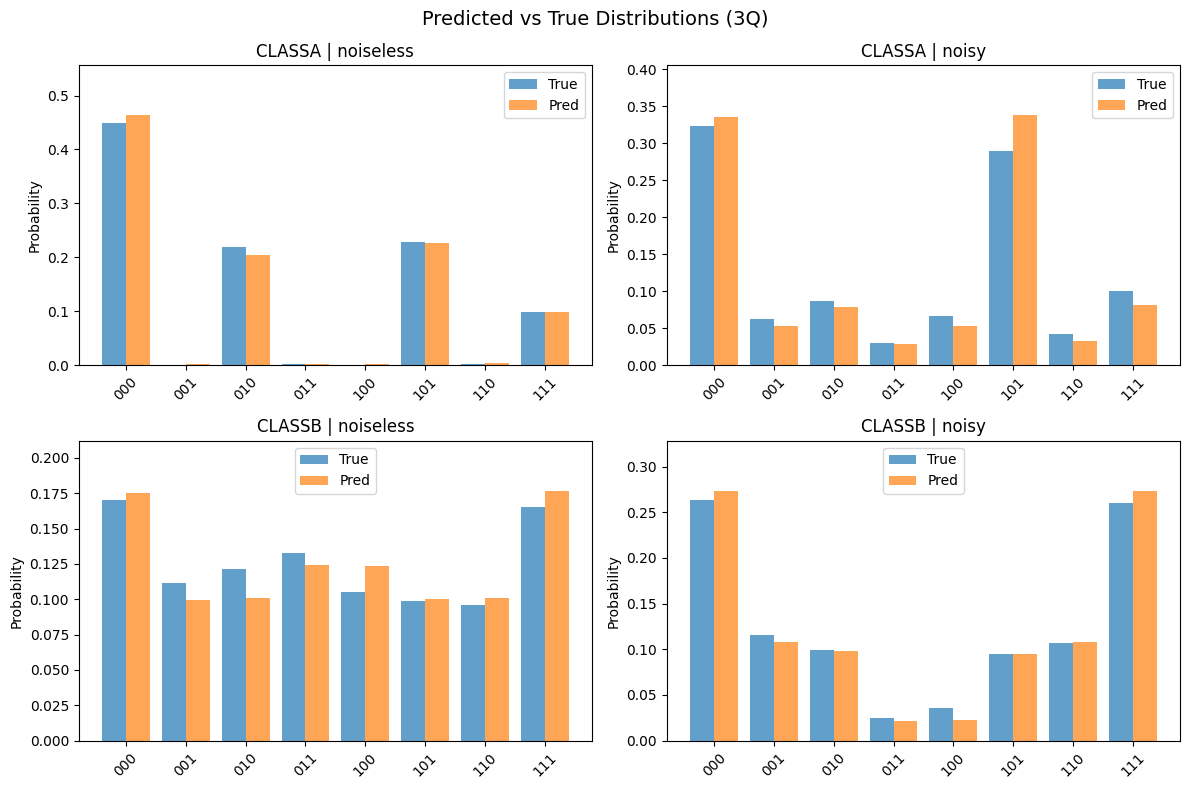

Saved model to ../models/gnn_models\3q_gnn.pt


In [20]:
run_qubit_experiment(3)

## 4-qubit experiment


4-Qubit GNN Experiment
Loaded 38400 samples.
Full set outcome entropy: 3.9894 bits
Train: 26872, Val: 7674, Test: 3854
Entropy 
Train: 3.9893, Val: 3.9897, Test: 3.9890
Model has 2,406,616 parameters.
Parameter not found in old model: convs.3.lin_key.weight
Parameter not found in old model: convs.3.lin_key.bias
Parameter not found in old model: convs.3.lin_query.weight
Parameter not found in old model: convs.3.lin_query.bias
Parameter not found in old model: convs.3.lin_value.weight
Parameter not found in old model: convs.3.lin_value.bias
Parameter not found in old model: convs.3.lin_edge.weight
Parameter not found in old model: convs.3.lin_skip.weight
Parameter not found in old model: convs.3.lin_skip.bias
Parameter not found in old model: bns.3.weight
Parameter not found in old model: bns.3.bias
Parameter not found in old model: bns.3.running_mean
Parameter not found in old model: bns.3.running_var
Parameter not found in old model: bns.3.num_batches_tracked
Loaded and interpolated w

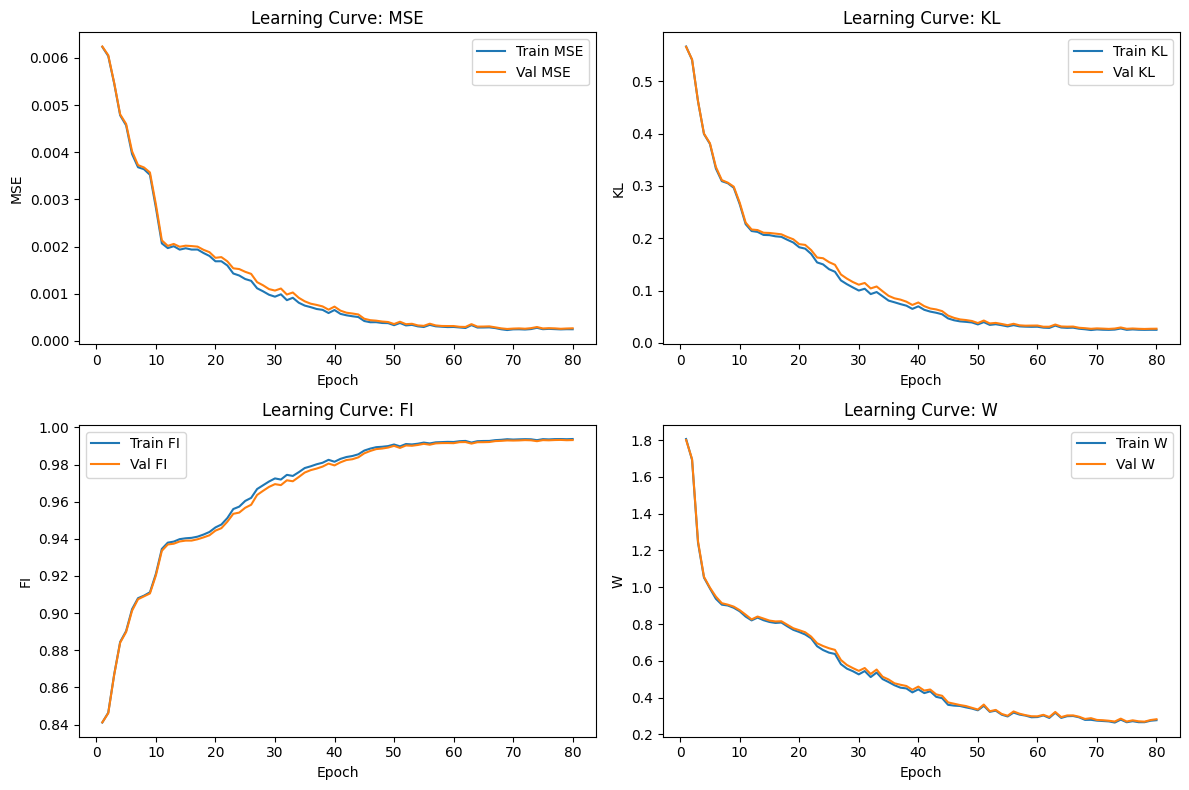

Evaluating on test set...
Group ('classA', 'noiseless') 
MSE: 0.000504 ± 0.000402 | KL: 0.050780 | FI: 0.987048 | W: 0.399310
Group ('classB', 'noiseless') 
MSE: 0.000093 ± 0.000065 | KL: 0.013547 | FI: 0.996312 | W: 0.185459
Group ('classB', 'noisy') 
MSE: 0.000079 ± 0.000049 | KL: 0.010371 | FI: 0.997413 | W: 0.175194
Group ('classA', 'noisy') 
MSE: 0.000375 ± 0.000295 | KL: 0.034298 | FI: 0.991947 | W: 0.375396
CLASSA | noiseless 
 MSE: 0.00050, KL: 0.05078, FI: 0.98705, W: 0.39931
CLASSB | noiseless 
 MSE: 0.00009, KL: 0.01355, FI: 0.99631, W: 0.18546
CLASSB | noisy     
 MSE: 0.00008, KL: 0.01037, FI: 0.99741, W: 0.17519
CLASSA | noisy     
 MSE: 0.00038, KL: 0.03430, FI: 0.99195, W: 0.37540
Plotting metric distributions on test set...


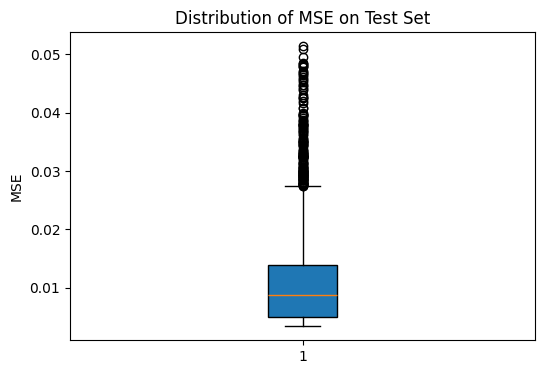

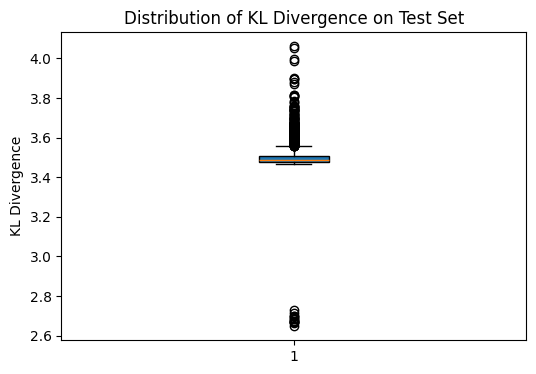

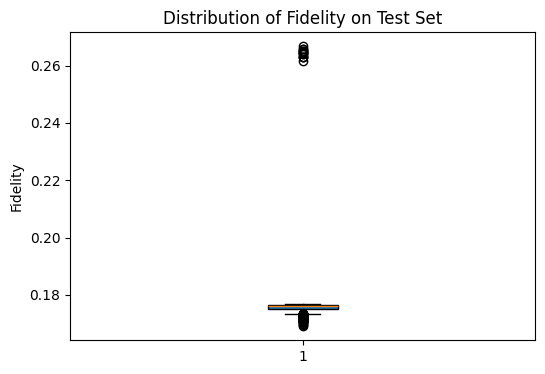

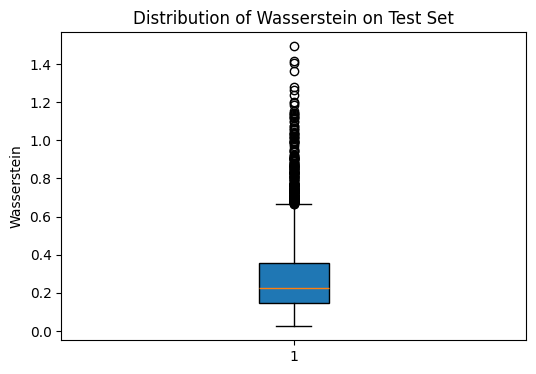

Visualizing predictions (per-group samples)...


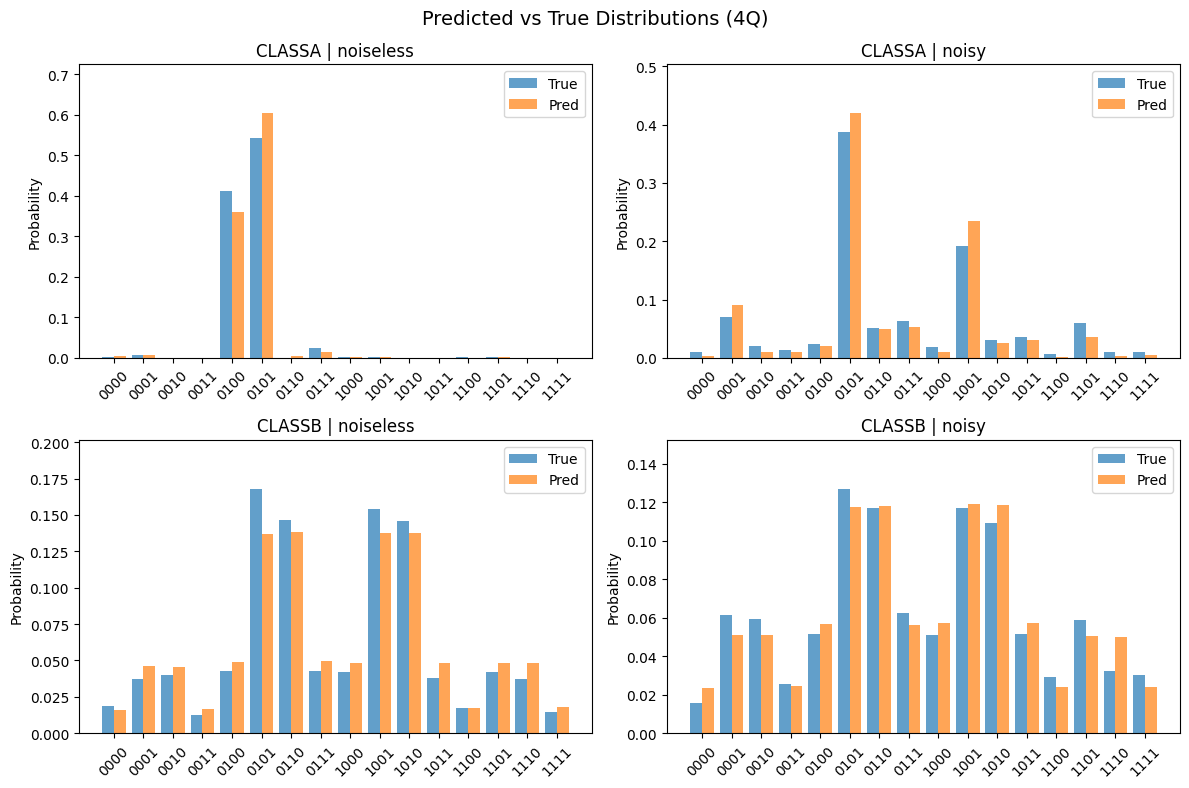

Saved model to ../models/gnn_models\4q_gnn.pt


In [21]:
run_qubit_experiment(4, epochs=80)

## 5-qubit experiment


5-Qubit GNN Experiment
Loaded 76800 samples.
Full set outcome entropy: 4.9838 bits
Train: 53745, Val: 15349, Test: 7706
Entropy 
Train: 4.9837, Val: 4.9838, Test: 4.9837
Model has 4,926,200 parameters.
Parameter not found in old model: convs.4.lin_key.weight
Parameter not found in old model: convs.4.lin_key.bias
Parameter not found in old model: convs.4.lin_query.weight
Parameter not found in old model: convs.4.lin_query.bias
Parameter not found in old model: convs.4.lin_value.weight
Parameter not found in old model: convs.4.lin_value.bias
Parameter not found in old model: convs.4.lin_edge.weight
Parameter not found in old model: convs.4.lin_skip.weight
Parameter not found in old model: convs.4.lin_skip.bias
Parameter not found in old model: bns.4.weight
Parameter not found in old model: bns.4.bias
Parameter not found in old model: bns.4.running_mean
Parameter not found in old model: bns.4.running_var
Parameter not found in old model: bns.4.num_batches_tracked
Loaded and interpolated 

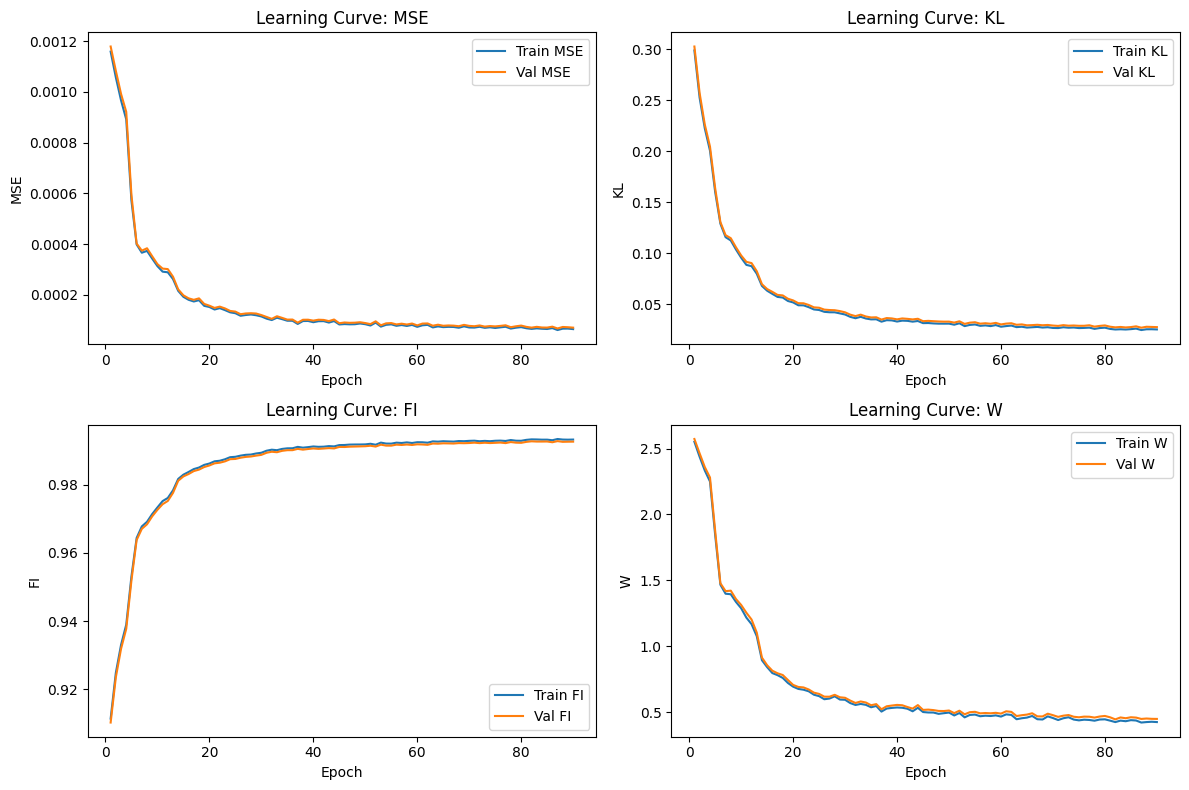

Evaluating on test set...
Group ('classB', 'noiseless') 
MSE: 0.000037 ± 0.000015 | KL: 0.019908 | FI: 0.994441 | W: 0.345992
Group ('classA', 'noiseless') 
MSE: 0.000120 ± 0.000122 | KL: 0.040897 | FI: 0.989091 | W: 0.599768
Group ('classB', 'noisy') 
MSE: 0.000034 ± 0.000012 | KL: 0.017851 | FI: 0.995457 | W: 0.339079
Group ('classA', 'noisy') 
MSE: 0.000095 ± 0.000074 | KL: 0.032667 | FI: 0.991693 | W: 0.528298
CLASSB | noiseless 
 MSE: 0.00004, KL: 0.01991, FI: 0.99444, W: 0.34599
CLASSA | noiseless 
 MSE: 0.00012, KL: 0.04090, FI: 0.98909, W: 0.59977
CLASSB | noisy     
 MSE: 0.00003, KL: 0.01785, FI: 0.99546, W: 0.33908
CLASSA | noisy     
 MSE: 0.00009, KL: 0.03267, FI: 0.99169, W: 0.52830
Plotting metric distributions on test set...


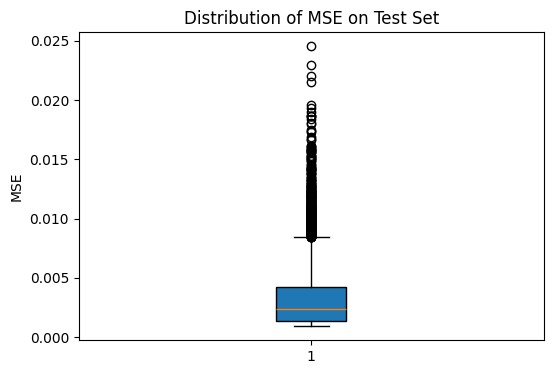

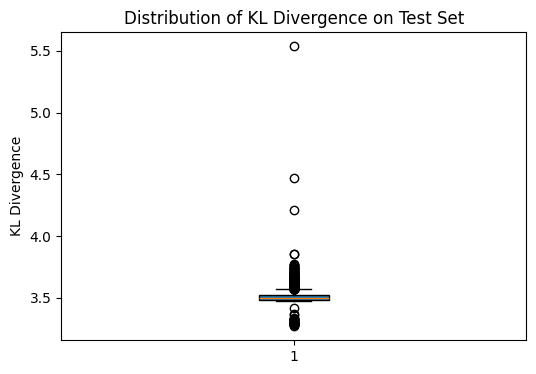

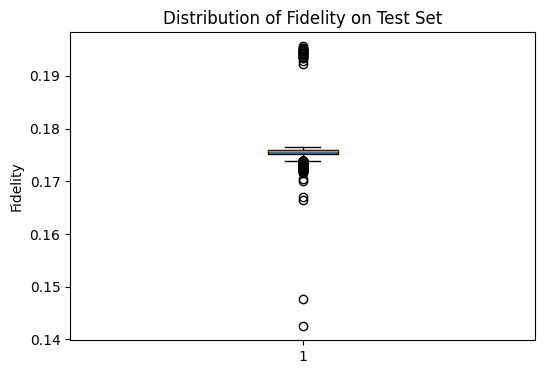

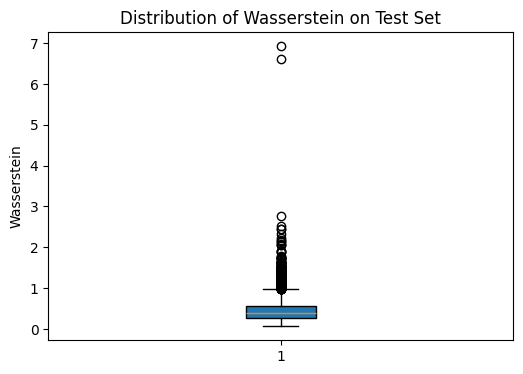

Visualizing predictions (per-group samples)...


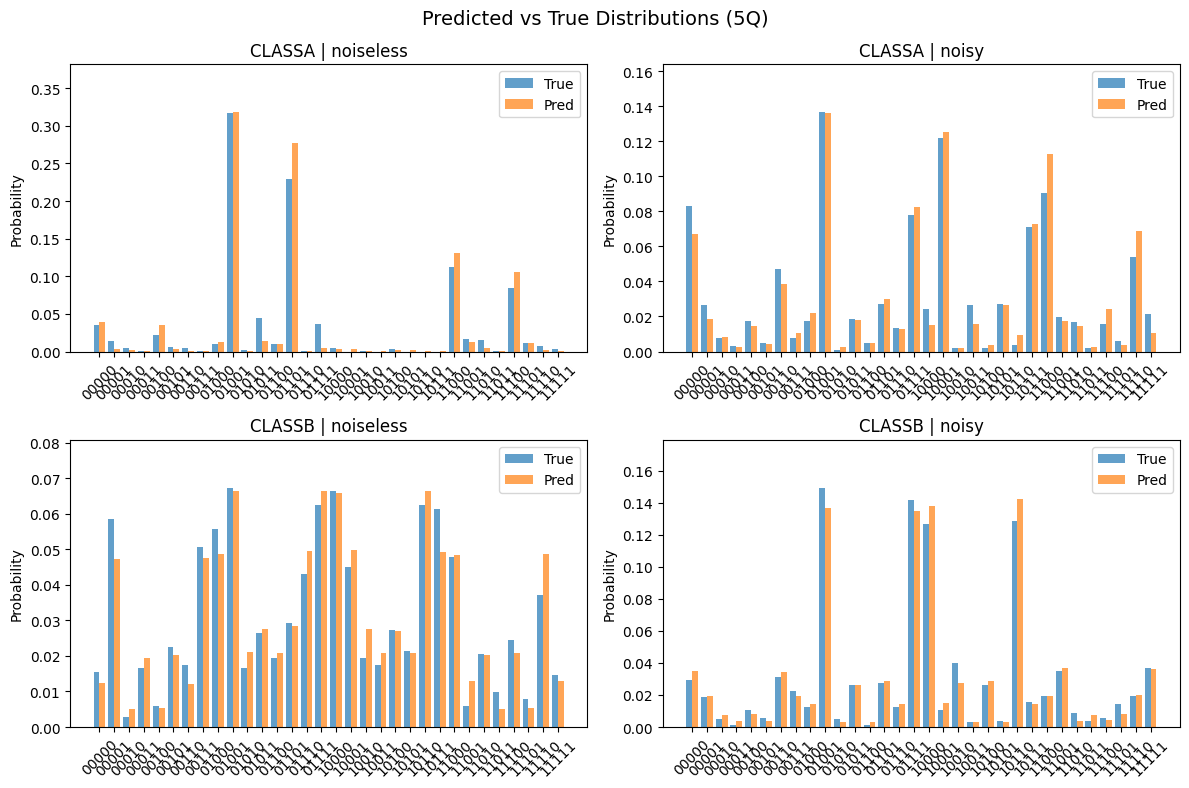

Saved model to ../models/gnn_models\5q_gnn.pt


In [22]:
run_qubit_experiment(5, epochs=90)